Loading latest log file: logs/PPO_manual_1770453085_PPO_timeStep_3000000.csv


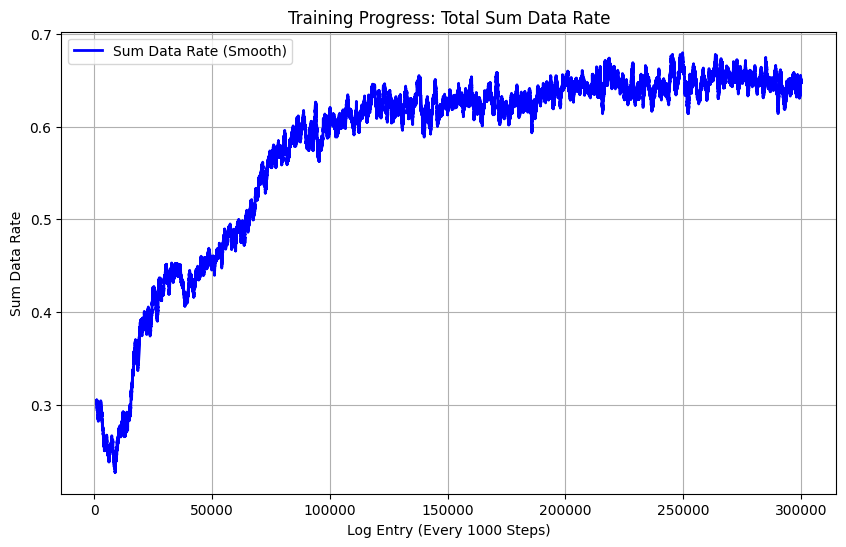

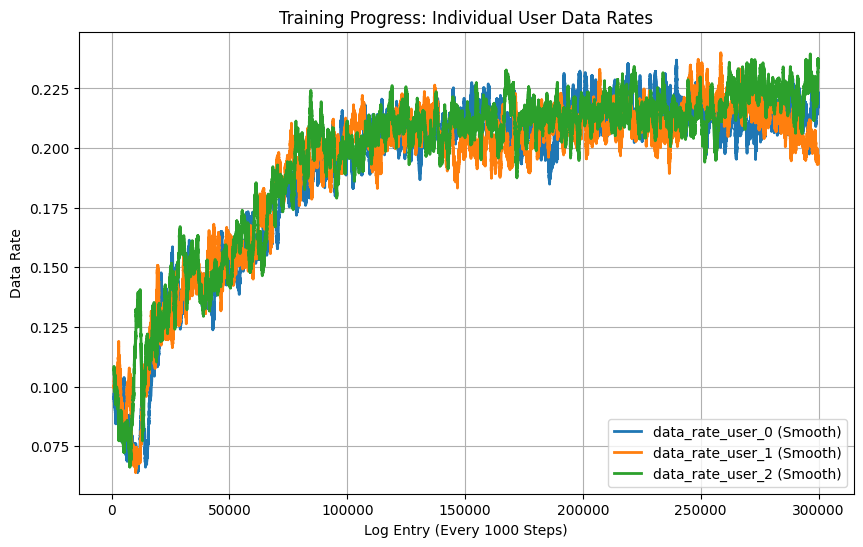

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob

# Find the latest CSV log file in the logs directory
log_dir = 'logs/'
# /Users/taduylam/Workspace/lab/MovableAntenna/logs/PPO_manual_1770401322_PPO_timeStep_1000000.csv
list_of_files = glob.glob(os.path.join(log_dir, '*.csv'))
if not list_of_files:
    print("No CSV log files found in logs/ directory.")
else:
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"Loading latest log file: {latest_file}")

    # Load the data
    df = pd.read_csv(latest_file)

    # Extract sum_data_rate (Objective: maximize this)
    if 'sum_data_rate' in df.columns:
        sum_data_rate = df['sum_data_rate'].values
    else:
        # Fallback if sum_data_rate is not directly available
        user_cols = [c for c in df.columns if c.startswith('data_rate_user_')]
        sum_data_rate = df[user_cols].sum(axis=1).values

    # 1. Plot Sum Data Rate
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    window_size = 1000
    rolling_mean_sum = pd.Series(sum_data_rate).rolling(window=window_size).mean()
    
    ax1.plot(rolling_mean_sum, color='blue', linewidth=2, label=f'Sum Data Rate (Smooth)')
    ax1.set_title('Training Progress: Total Sum Data Rate')
    ax1.set_xlabel('Log Entry (Every 1000 Steps)')
    ax1.set_ylabel('Sum Data Rate')
    ax1.legend()
    plt.grid(True)
    plt.show()

    # 2. Plot Individual User Data Rates
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    user_cols = [c for c in df.columns if c.startswith('data_rate_user_')]
    
    for col in user_cols:
        user_data = df[col].values
        # Smoothen individual user rate
        smoothed_user = pd.Series(user_data).rolling(window=window_size).mean()
        ax2.plot(smoothed_user, linewidth=2, label=f'{col} (Smooth)')

    ax2.set_title('Training Progress: Individual User Data Rates')
    ax2.set_xlabel('Log Entry (Every 1000 Steps)')
    ax2.set_ylabel('Data Rate')
    ax2.legend()
    plt.grid(True)
    plt.show()

--- EVALUATING MODEL STABILITY (10000 Episodes) ---
Model: /Users/taduylam/Workspace/lab/MovableAntenna/models/PPO_final_1770405457.pth
Model loaded successfully.
Running simulation...
check beam
check beam
check position
check beam
check SINR
check beam
check SINR
check SINR
check beam
check beam
check SINR
check position
check SINR
check beam
check SINR
check beam
check beam
check beam
check beam
check beam
check beam
check beam
check position
check beam
check beam
check beam
check beam
check beam
check beam
check beam
check beam
check SINR
check beam
check beam
Episode 1000/10000 | Current Rate: 0.7729 | Avg so far: 0.6387
check beam
check beam
check beam
check beam
check beam
check beam
check SINR
check SINR
check position
check SINR
check position
check beam
check beam
check SINR
check beam
check beam
check SINR
check beam
check beam
check beam
check beam
check SINR
check beam
check SINR
check beam
check SINR
check beam
Episode 2000/10000 | Current Rate: 1.2811 | Avg so far: 0.635

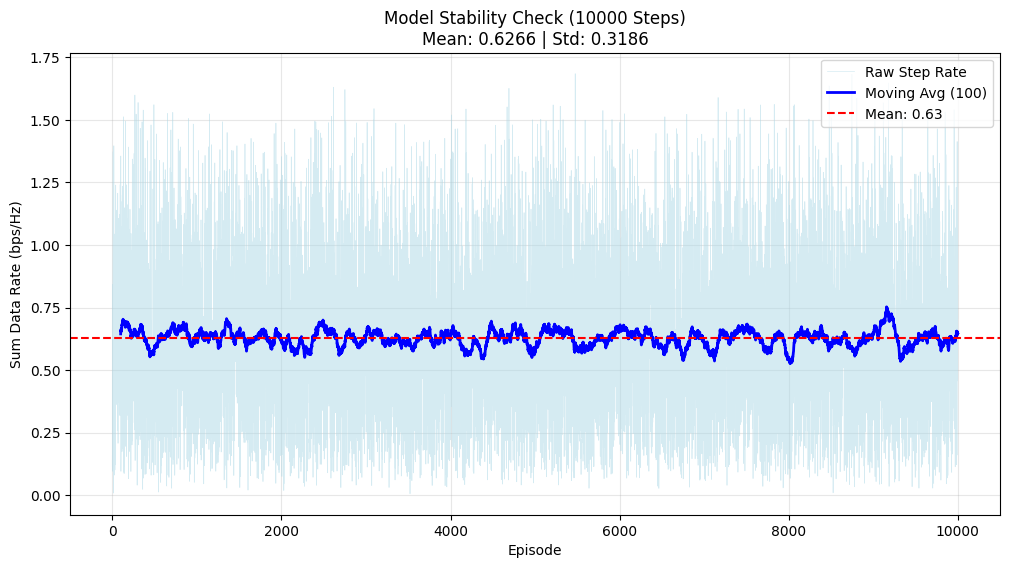

In [3]:
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

from environment import SecCom_Env
from ppo import PPOAgent
from system_configuration import Config

def flatten_obs(obs):
    field_vec = obs["user_field_response_vector"].flatten()
    data_rate = obs["user_data_rate"].flatten()
    return np.concatenate([field_vec, data_rate])

MODEL_PATH = "/Users/taduylam/Workspace/lab/MovableAntenna/models/PPO_final_1770405457.pth"
TEST_EPISODES = 10000

print(f"--- EVALUATING MODEL STABILITY ({TEST_EPISODES} Episodes) ---")
print(f"Model: {MODEL_PATH}")

# Setup Env
cfg = Config()
cfg.init_unstatic_value()
env = SecCom_Env(cfg)

# Dims
obs_shape = env.observation_shape["user_field_response_vector"]
obs_dim = (obs_shape[0] * obs_shape[1]) + env.observation_shape["user_data_rate"][0]
action_dim = env.action_dim

# Load Agent
agent = PPOAgent(obs_dim, action_dim)
if os.path.exists(MODEL_PATH):
    agent.load(MODEL_PATH)
    print("Model loaded successfully.")
else:
    print(f"ERROR: Model not found at {MODEL_PATH}")
    exit(1)

# Run Simulation
rates = []
rewards = []

start_time = time.time()
print("Running simulation...")

for ep in range(TEST_EPISODES):
    state, info = env.reset()
    state = flatten_obs(state)
    
    # Select Action
    action, _, _ = agent.select_action(state)
    
    next_state, reward, terminated, truncated, info = env.step(action)
    
    sum_rate = np.sum(info['user_data_rate'])
    rates.append(sum_rate)
    rewards.append(reward)
    
    if (ep + 1) % 1000 == 0:
        print(f"Episode {ep+1}/{TEST_EPISODES} | Current Rate: {sum_rate:.4f} | Avg so far: {np.mean(rates):.4f}")

elapsed = time.time() - start_time
print(f"Simulation finished in {elapsed:.2f}s")

# Stats
avg_rate = np.mean(rates)
std_rate = np.std(rates)
max_rate = np.max(rates)
min_rate = np.min(rates)

print("\n--- RESULTS ---")
print(f"Mean Sum Rate: {avg_rate:.4f}")
print(f"Std Dev:       {std_rate:.4f}")
print(f"Max Rate:      {max_rate:.4f}")
print(f"Min Rate:      {min_rate:.4f}")

# Visualization
plt.figure(figsize=(12, 6))

# Raw Data (Light)
plt.plot(rates, color='lightblue', alpha=0.5, label='Raw Step Rate', linewidth=0.5)

# Moving Average (Dark)
window = 100
series = pd.Series(rates)
ma = series.rolling(window=window).mean()
plt.plot(ma, color='blue', linewidth=2, label=f'Moving Avg ({window})')

plt.axhline(avg_rate, color='red', linestyle='--', label=f'Mean: {avg_rate:.2f}')

plt.title(f"Model Stability Check ({TEST_EPISODES} Steps)\nMean: {avg_rate:.4f} | Std: {std_rate:.4f}")
plt.xlabel("Episode")
plt.ylabel("Sum Data Rate (bps/Hz)")
plt.legend()
plt.grid(True, alpha=0.3)

save_path = f"evaluation_10k_{int(time.time())}.png"
plt.savefig(save_path)
print(f"Plot saved to: {save_path}")
